# Creating a Linear Factor Model Here

In [73]:
from strategy import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [470]:
class Strategy():
    def __init__(self):
        pass

    def handle_update(self, inx, price, factors):
        """Put your logic here
        Args:
            inx: zero-based inx in days
            price: [num_assets, ]
            factors: [num_assets, num_factors]
        Return:
            allocation: [num_assets, ]
        """
        assert price.shape[0] == factors.shape[0]
        return np.array([1.0] * price.shape[0])

In [517]:
class Preprocessing():
    
    """We transform the data when we iterate through it."""
    
    def __init__(self, train_prices, train_factors):
        """
        Below we have x represent the time interval the train data is over 
        and z represents the number of factors that are included. We are going to need
        a factor scaler for every stock and just one to modify the prices.
        
        Args:
            train_prices: (x+1,680) 
            train_factors: (x,680,z)
        
        """
        #Storing the last price for return calculations
        self.last_price = train_prices[-1,:]
        
        #Initializing Scalers
        self.factor_scalers = [StandardScaler() for i in range(train_factors.shape[1])]
        self.return_scaler = StandardScaler()
        
        #Calculating Daily Returns
        train_returns=((train_prices[1:]-train_prices[:-1])/train_prices[:-1])
        
        #Updating Factor Scalers
        for i in range(len(self.factor_scalers)):
            self.factor_scalers[i].partial_fit(train_factors[:,i,:])
            
        #Updating Returns
        self.return_scaler.partial_fit(train_returns)
        
    def handle_update_factors(self,factors_update):
        """
        Expect the update to be in the form of (1,680,z) where z is the number of factors we are considering
        """
        transformed_output = []
        for i in range(len(self.factor_scalers)):
            self.factor_scalers[i].partial_fit(factors_update[i,:])
            transformed_output.append(self.factor_scalers[i].transform(factors_update[i,:]))
        
        #With this update we plug in to obtain the return with the loading matrix
        return np.array(transformed_output).swapaxes(0,1)
        
    def handle_update_price(self,price_update):
        """
        Expect the update to be in the form of (680)
        """
        #Using Normal Returns Since log Returns was not very effective
        return_value = (price_update-last_price)/last_price
        last_price = price_update
        transformed_output=self.return_scaler.partial_fit(price_update)
        
        #With this update we attempt to refactor the loading matrix
        return np.array(transformed_output)
    
    def inverse_transform_return(self,r_prediction):
        """
        r_prediction (680) from the factor model to be transformed into tangible returns
        """
        self.return_scaler.inverse_transform(r_prediction)
    
    def normalize_factors(self,factor_data):
        transformed_output = []
        for i in range(len(self.factor_scalers)):
            transformed_output.append(self.factor_scalers[i].transform(factor_data[:,i,:]))
        return np.array(transformed_output)
        
    def normalize_returns(self,return_data):
        return self.return_scaler.transform(return_data)
    
    def derive_returns(self, price_data):
        return ((price_data[1:]-price_data[:-1])/price_data[:-1])

#Need to calculate the returns with the Preprocessing (Normalization) Scheme
#Need to calculate the Covariance Matrix
#Could use upper quartile balancing, or could use more conservative techniques
#Need to control the outputs, create a classs to dynamically try to push the return higher under the current constraits: optimizer class


# class FactorModel():
    
#     def __init__(self,returns, factors):
#         self.returns
#         Pre
        
#     def fit():
        
#     def update(price):
        
        
#     def load_
    
#     def initializeScaler():
        

# Importing and Processing the Data

In [572]:
prices = load_object("C3_train.pkl")['prices']
features = load_object("C3_train.pkl")['features']
preprocess = Preprocessing(prices,features['values'])
factors = preprocess.normalize_factors(features['values'])
returns = preprocess.derive_returns(prices)
normalized_returns = preprocess.normalize_returns(returns)

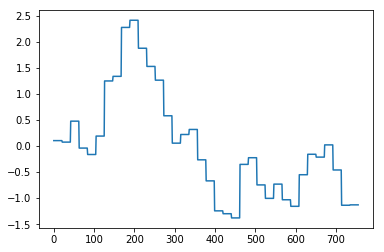

In [541]:
plt.plot(factors[0,:,0])

# Splitting the Data for Backtesting

In [552]:
def train_test_split(price_data,feature_data,ratio=0.7):
    train_size = int(ratio*price_data.shape[0])

    train_price = price_data[:train_size+1,:]
    train_feature = feature_data[:train_size,:,:]
    
    test_price = price_data[train_size:,:]
    test_feature = feature_data[train_size:,:,:]
    
    return train_price, train_feature, test_price, test_feature

In [571]:
factors.shape

(529, 529, 10)

In [576]:
train_price, train_features, test_price, test_features = train_test_split(prices,features['values'])

In [577]:
test_preprocess = Preprocessing(train_price,train_features)

In [579]:
train_features.shape

(529, 680, 10)

In [580]:
factors = test_preprocess.normalize_factors(train_features)
returns = test_preprocess.derive_returns(train_price)
normalized_returns = preprocess.normalize_returns(returns)

In [585]:
normalized_returns.shape

(529, 680)

In [583]:
factors.shape

(680, 529, 10)

In [670]:
#Given factor and return data, remove the periodicity present in the factor data by averaging returns and determine a lienar relationship
def remove_factor_periodicity(factor, returns):
    unique_factors = np.unique(factor)
    unique_factor_masks = [factor==i for i in unique_factors]
    average_returns = np.array([np.mean(returns[factor_masks]) for factor_masks in unique_factor_masks])
    return unique_factors, average_returns

In [711]:
%timeit f,r = remove_factor_periodicity(factors[0,:,6],normalized_returns[:,6])

646 µs ± 90.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


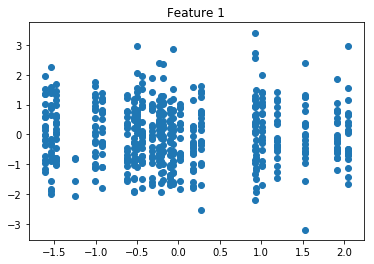

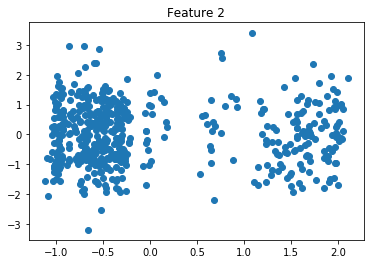

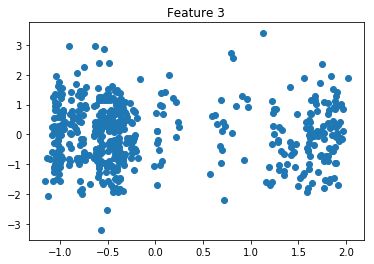

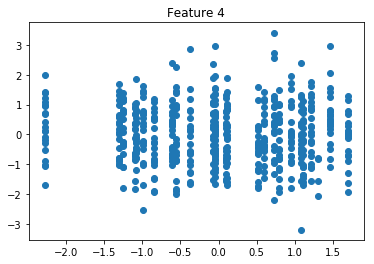

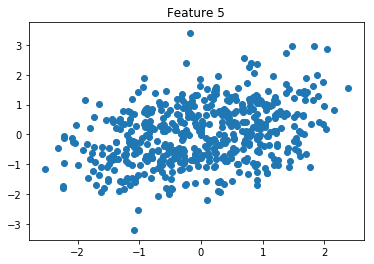

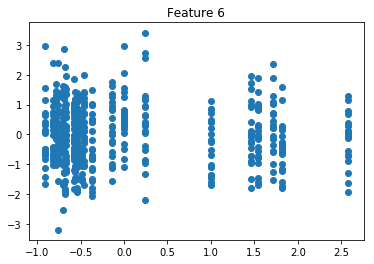

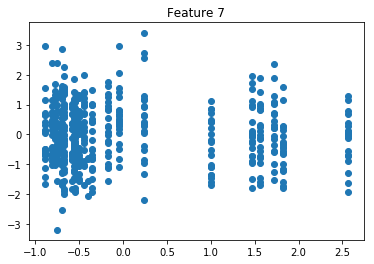

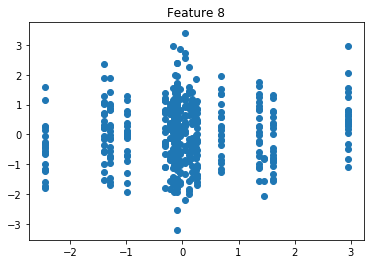

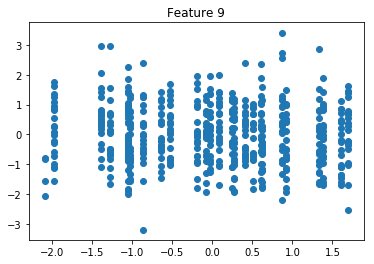

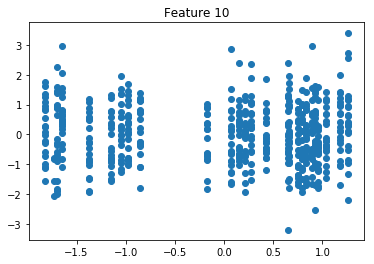

In [686]:
#We are going to display the normalized mean relationships
for i in range(10):
    plt.figure()
    plt.title("Feature {}".format(i+1))
    plt.scatter(factors[0,:,i],normalized_returns[:,0])

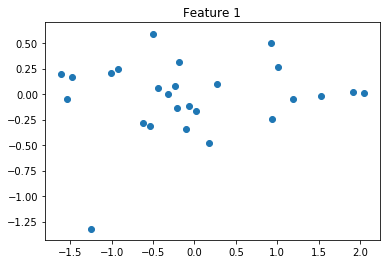

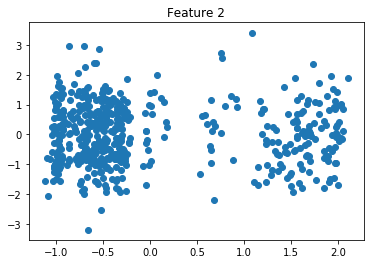

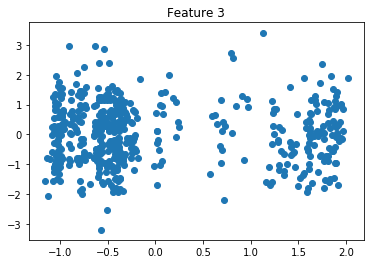

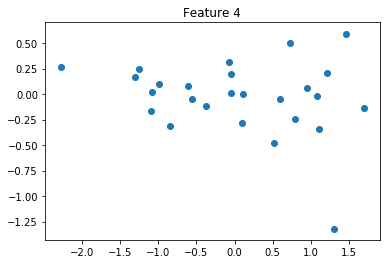

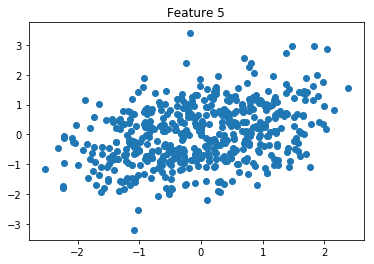

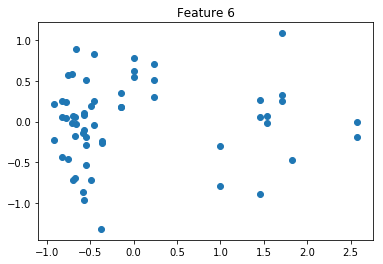

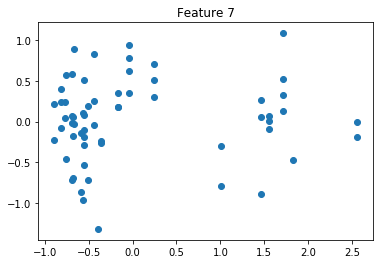

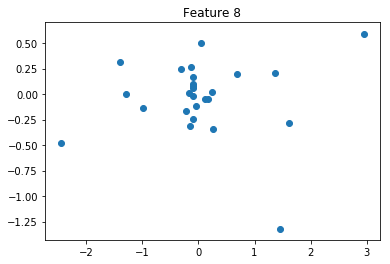

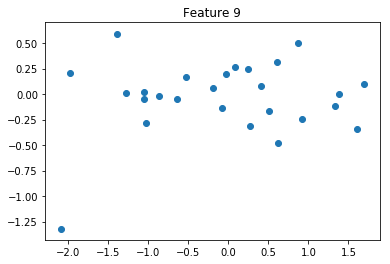

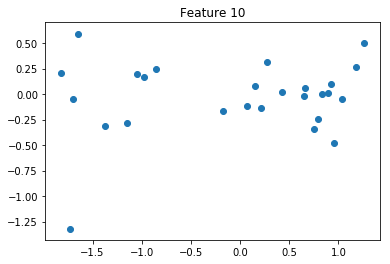

In [687]:
#We are going to display the normalized mean relationships
for i in range(10):
    plt.figure()
    plt.title("Feature {}".format(i+1))
    f,r = remove_factor_periodicity(factors[0,:,i],normalized_returns[:,0])
    plt.scatter(f,r)

# Using Feature 5

In [88]:
FactorAnalysis?
FA = FactorAnalysis(n_components=3)
factors = FA.fit_transform(price_data)
FA.components_
plt.plot(factors[:,2])

# Multivariate OLS

In [688]:
import statsmodels.api as sm

In [690]:
X = factors[0,:,:]
y = normalized_returns[:,0]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

In [710]:
%timeit model = sm.OLS(y, X).fit()

532 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [692]:
predictions.shape

(529,)

In [708]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     12.11
Date:                Sun, 31 Mar 2019   Prob (F-statistic):           6.12e-19
Time:                        10:20:45   Log-Likelihood:                -694.56
No. Observations:                 529   AIC:                             1409.
Df Residuals:                     519   BIC:                             1452.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0833      0.106      0.788      0.431      -0.124       0.291
x2             4.1243      1.404      2.938      0.003       1.366       6.882
x3            -3.2807      1.460     -2.248      0.025      -6.148      -0.413
x4             0.0835      0.066      1.264      0.207      -0.046       0.213
x5             0.4890      0.049     10.051      0.000       0.393       0.585
x6            19.9273      7.184      2.774      0.006       5.814      34.041
x7           -20.8316      7.318     -2.847      0.005     -35.208      -6.455
x8            -0.1523      0.080     -1.914      0.056      -0.309       0.004
x9            -0.0010      0.074     -0.014      0.989      -0.146       0.144
x10            0.0832      0.145      0.573      0.567      -0.202       0.369
==============================================================================
Omnibus:                        1.273   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.260
Skew:                          -0.032   Prob(JB):                        0.533
Kurtosis:                       2.770   Cond. No.                         577.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

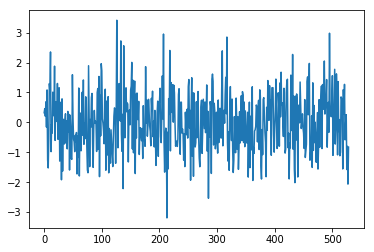

In [698]:
plt.plot(y)

In [ ]:
plt.plot(y)

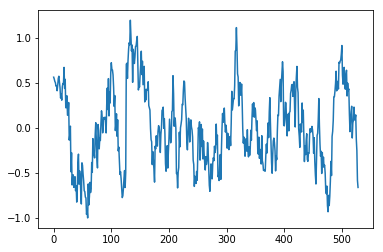

In [695]:
plt.plot(predictions)